In [2]:
#!pip install geemap

**1. Installing libraries**

In [1]:
import os
import ee
import geemap
import pandas as pd
import numpy as np

In [2]:
# geemap.update_package()

**2. Authenticate and initialize Earth Engine**

In [3]:
ee.Authenticate()

Enter verification code: 4/1AWtgzh6f7bvtlhtK5jvjziXUxIOpK1fzpPycDqPJgblnPjI52I7MNu_SqM8

Successfully saved authorization token.


In [4]:
ee.Initialize()

**3. Converting JS code -> Python**

In [8]:
# js_snippet = """
# var maskL8sr = function(image) {
#   // Bit 0 - Fill
#   // Bit 1 - Dilated Cloud
#   // Bit 2 - Cirrus
#   // Bit 3 - Cloud
#   // Bit 4 - Cloud Shadow
#   var qaMask = image.select('QA_PIXEL').bitwiseAnd(parseInt('11111', 2)).eq(0);
#   var saturationMask = image.select('QA_RADSAT').eq(0);

#   // Apply the scaling factors to the appropriate bands.
#   var opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2);
#   var thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0);

#   // Replace the original bands with the scaled ones and apply the masks.
#   return image.addBands(opticalBands, null, true)
#     .addBands(thermalBands, null, true)
#     .updateMask(qaMask)
#     .updateMask(saturationMask);
# };
# """
# geemap.js_snippet_to_py(
#     js_snippet, add_new_cell=True, import_ee=True, import_geemap=True, show_map=True
# )

**Creating Region Of Interest = USA, & map**

In [5]:
countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017");
roi = countries.filter(ee.Filter.eq("country_na", "United States"))

Map = geemap.Map()

**Initializing dataset (landsat 8)**

In [36]:
%time

# adding time to image


# Applies scaling factors.
def applyScaleFactors(image):
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBands = image.select('ST_B10').multiply(0.00341802).add(149.0)
  LonLat = image.pixelLonLat()
  image = image.addBands(opticalBands, None, True) \
              .addBands(thermalBands, None, True) \
              .addBands(LonLat) \
              .clip(roi) 
  return image

def addDate(image):
    time = image.metadata('system:time_start')
    return image.addBands(time.rename('time'))



bands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'longitude', 'latitude', 'time']



dataset = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate('2021-05-01', '2021-06-01') \
    .filterBounds(roi) \
    .map(applyScaleFactors) \
    .map(addDate) \
    .select(bands) \
    .mosaic()

visualization = {
  'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
  'min': 0.0,
  'max': 0.3,
}

Map.centerObject(roi, 4)
Map.addLayer(dataset, visualization, 'Landsat 8')


Map


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 12.6 µs


Map(bottom=1854.0, center=[39.76850680995396, -99.05366228420321], controls=(WidgetControl(options=['position'…

**Extracting data of US cities**

In [37]:
%%time
work_dir = os.path.expanduser('/Users/artemzaharov/opt/miniconda3/envs/project_gee/data')
in_shp = os.path.join(work_dir, 'us_cities.shp')
if not os.path.exists(in_shp):
    data_url = 'https://github.com/giswqs/data/raw/main/us/us_cities.zip'
    geemap.download_from_url(data_url, out_dir=work_dir)
    
in_fc = geemap.shp_to_ee(in_shp)
Map.addLayer(in_fc, {}, 'Cities')

CPU times: user 717 ms, sys: 44.4 ms, total: 761 ms
Wall time: 8.96 s


**Export pixel values to csv**

In [39]:
dataset.bandNames()

In [41]:
%%time
out_csv = os.path.join(work_dir, 'Landsat8.csv')
geemap.extract_values_to_points(in_fc, dataset, out_csv, 30)

Generating URL ...
Please wait ...
Data downloaded to /Users/artemzaharov/opt/miniconda3/envs/project_gee/data/Landsat8.csv
CPU times: user 2.21 s, sys: 290 ms, total: 2.5 s
Wall time: 1min 3s


In [10]:
df_Landsat = pd.read_csv('/Users/artemzaharov/opt/miniconda3/envs/project_gee/data/Landsat8.csv')
df_Landsat = df_Landsat.dropna(in_fc)

In [495]:
import datetime
# converting date dd.mm.YY
def convertDate(value):
    time = datetime.datetime.fromtimestamp(value/1000.0)
    return time.strftime('%Y-%m-%d')
df_Landsat['date'] = df_Landsat['time'].apply(convertDate)

# converting date HH:MM:SS
def convertTime(value):
    time = datetime.datetime.fromtimestamp(value/1000.0)
    return time.strftime('%H:00') # %H:%M:%S
df_Landsat['time'] = df_Landsat['time'].apply(convertTime)

# moving time and date to the front of the table
df_Landsat = df_Landsat[['time'] + [x for x in df_Landsat.columns if x != 'time']]
df_Landsat = df_Landsat[['date'] + [x for x in df_Landsat.columns if x != 'date']]


In [496]:
df_epa = pd.read_csv('/Users/artemzaharov/opt/miniconda3/envs/project_gee/data/hourly_81102_2021.csv')

In [497]:
df_Landsat.head()

,date,time,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,longitude,latitude,system:index,STATE,ELEV_IN_FT,POP_2010,id
0,2021-05-27,20:00,0.591643,0.579487,0.570275,0.566288,0.580753,0.235682,0.261395,-101.296142,48.232389,0,ND,1611,40888,53
1,2021-05-22,20:00,0.972435,0.972160,0.926565,0.917435,0.908085,0.552565,0.352887,-97.032738,47.925165,1,ND,830,52838,101
2,2021-05-29,20:00,0.991273,0.981070,0.927913,0.914960,0.895655,0.519373,0.403817,-98.708455,46.910518,2,ND,1407,15427,153
3,2021-05-22,20:00,0.545525,0.547285,0.534415,0.542775,0.608693,0.533287,0.451997,-96.789924,46.877101,3,ND,902,105549,177
4,2021-05-18,20:00,0.055365,0.084817,0.144575,0.161268,0.178207,0.218825,0.213188,-102.789681,46.879257,4,ND,2411,17787,192


In [498]:
df_epa.head()

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Date Local,...,Units of Measure,MDL,Uncertainty,Qualifier,Method Type,Method Code,Method Name,State Name,County Name,Date of Last Change
0,1,73,23,81102,4,33.553056,-86.815,WGS84,PM10 Total 0-10um STP,2021-01-01,...,Micrograms/cubic meter (25 C),0.1,NaN,NaN,FEM,239,Teledyne API T640X at 16.67 LPM - Broadband sp...,Alabama,Jefferson,2021-04-20
1,1,73,23,81102,4,33.553056,-86.815,WGS84,PM10 Total 0-10um STP,2021-01-01,...,Micrograms/cubic meter (25 C),0.1,NaN,NaN,FEM,239,Teledyne API T640X at 16.67 LPM - Broadband sp...,Alabama,Jefferson,2021-04-20
2,1,73,23,81102,4,33.553056,-86.815,WGS84,PM10 Total 0-10um STP,2021-01-01,...,Micrograms/cubic meter (25 C),0.1,NaN,NaN,FEM,239,Teledyne API T640X at 16.67 LPM - Broadband sp...,Alabama,Jefferson,2021-04-20
3,1,73,23,81102,4,33.553056,-86.815,WGS84,PM10 Total 0-10um STP,2021-01-01,...,Micrograms/cubic meter (25 C),0.1,NaN,NaN,FEM,239,Teledyne API T640X at 16.67 LPM - Broadband sp...,Alabama,Jefferson,2021-04-20
4,1,73,23,81102,4,33.553056,-86.815,WGS84,PM10 Total 0-10um STP,2021-01-01,...,Micrograms/cubic meter (25 C),0.1,NaN,NaN,FEM,239,Teledyne API T640X at 16.67 LPM - Broadband sp...,Alabama,Jefferson,2021-04-20


In [43]:
'''import time
start_time = time.time()


values = {}
for ind in (df_Landsat['system:index']):
    i = df_Landsat[df_Landsat['system:index'] == ind].index[0]
    indexes_date = df_epa[df_epa['Date Local'] == df_Landsat['date'][i]].index
    time = pd.Timestamp(df_Landsat['time'][i])
    time1 = str((time + pd.Timedelta(hours = -1)).strftime('%H:00'))
    time2 = str((time + pd.Timedelta(hours = 1)).strftime('%H:00'))
    indexes_time = df_epa[df_epa['Time Local'] == df_Landsat['time'][i]].index
    indexes_time1 = df_epa[df_epa['Time Local'] == time1].index
    indexes_time2 = df_epa[df_epa['Time Local'] == time2].index
    time = indexes_time.append(indexes_time1).append(indexes_time2)
    answer = indexes_date.intersection(indexes_time)
    indexes_lon = df_epa[np.abs(df_epa['Longitude'] - df_Landsat['longitude'][i]) <= 1].index
    answer = answer.intersection(indexes_lon)
    indexes_lat = df_epa[np.abs(df_epa['Latitude'] - df_Landsat['latitude'][i]) <= 1].index
    answer = answer.intersection(indexes_lat)
    values[i] = answer
    print(i)

end_time = time.time()
print("Time elapsed: ", end_time - start_time, "seconds")'''
print('•takes too much time\n•needed to be easier')

•takes too much time
•needed to be easier


# Creating Dataset

In [501]:
count = 0
with open('/Users/artemzaharov/opt/miniconda3/envs/project_gee/data/finalData.csv', 'w') as f:
#     f.write('index;lon_Landsat;lat_Landsat;data_Lansat;time_Landsat;lon_Epa;lat_Epa;data_Epa;time_Epa;SR_B1;SR_B2;SR_B3;SR_B4;SR_B5;SR_B6;SR_B7;value_Epa\n')
    f.write('index,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,value_Epa\n')
    for key, val in values.items():
        if (val.any()):
            f.write(str(count) + ',') # index
#             f.write(str(df_Landsat['longitude'][key]) + ';') # lon_Landsat
#             f.write(str(df_Landsat['latitude'][key]) + ';') # lat_Landsat
#             f.write(str(df_Landsat['date'][key]) + ';') # data_Lansat
#             f.write(str(df_Landsat['time'][key]) + ';') # time_Landsat
            
#             f.write(str(df_epa['Longitude'][val[0]]) + ';') # lon_Epa
#             f.write(str(df_epa['Latitude'][val[0]]) + ';') # lat_Epa
#             f.write(str(df_epa['Date Local'][val[0]]) + ';') # data_Epa
#             f.write(str(df_epa['Time Local'][val[0]]) + ';') # time_Epa
            
            f.write(str(df_Landsat['SR_B1'][key]) + ',') # SR_B1
            f.write(str(df_Landsat['SR_B2'][key]) + ',') # SR_B2
            f.write(str(df_Landsat['SR_B3'][key]) + ',') # SR_B3
            f.write(str(df_Landsat['SR_B4'][key]) + ',') # SR_B4
            f.write(str(df_Landsat['SR_B5'][key]) + ',') # SR_B5
            f.write(str(df_Landsat['SR_B6'][key]) + ',') # SR_B6
            f.write(str(df_Landsat['SR_B7'][key]) + ',') # SR_B7
            
            # Sample Measurement of PM10
            f.write(str(df_epa['Sample Measurement'][val[0]]) + '\n')
            count += 1
print(count)

2806


In [477]:
df = pd.read_csv('/Users/artemzaharov/opt/miniconda3/envs/project_gee/data/finalData.csv')
df.head() # separator should be ','

,index,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,value_Epa
0,0,0.055365,0.084817,0.144575,0.161268,0.178207,0.218825,0.213188,36.0
1,1,0.640950,0.625522,0.592165,0.586665,0.603880,0.217477,0.233950,8.2
2,2,0.692182,0.691577,0.612955,0.622003,0.686243,0.446580,0.350605,8.1
3,3,0.050855,0.060260,0.090510,0.095762,0.243053,0.192233,0.137508,16.2
4,4,0.030807,0.037738,0.070490,0.056437,0.280975,0.164100,0.107862,16.2


## **Preparing Data as X and Y**

In [478]:
y = df['value_Epa']

x = df.drop('value_Epa', axis = 1)

## Spliting data

In [479]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 100)

# Buinding "Linear Regression" Model

## Training model

In [480]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

## Applying the model to make prediction

In [481]:
y_lr_train_pred = lr.predict(x_train)
y_lr_test_pred = lr.predict(x_test)

## Evaluate model performance 

In [482]:
from sklearn.metrics import mean_squared_error, r2_score

lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)

lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)

In [483]:
lr_results = pd.DataFrame(['Linear regression', lr_train_mse, lr_train_r2, lr_test_mse, lr_test_r2]).transpose()
lr_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
lr_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Linear regression,162.518657,0.056291,201.037277,0.020074


# Building "Random Forest" Model

## Training model

In [484]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth = 2, random_state = 100)
rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=2, random_state=100)

## Applying the model to make prediction

In [485]:
y_rf_train_pred = rf.predict(x_train)
y_rf_test_pred = rf.predict(x_test)


## Evaluate model performance 

In [486]:
from sklearn.metrics import mean_squared_error, r2_score

rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_train_r2 = r2_score(y_train, y_rf_train_pred)

rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)

In [487]:
rf_results = pd.DataFrame(['Random forest', rf_train_mse, rf_train_r2, rf_test_mse, rf_test_r2]).transpose()
rf_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
rf_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Random forest,152.581068,0.113996,196.299409,0.043168


# Models Accuracy

In [488]:
df_models = pd.concat([lr_results, rf_results], axis = 0).reset_index(drop = True)
df_models

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Linear regression,162.518657,0.056291,201.037277,0.020074
1,Random forest,152.581068,0.113996,196.299409,0.043168


[]

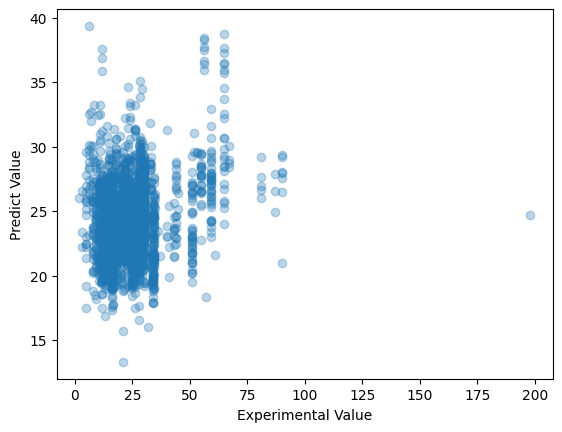

In [489]:
import matplotlib.pyplot as plt

plt.scatter(x = y_train, y = y_lr_train_pred, alpha = 0.3)
plt.ylabel('Predict Value')
plt.xlabel('Experimental Value')
plt.plot()

In [493]:
df.describe()

,index,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,value_Epa
count,2806.000000,2806.000000,2806.000000,2806.000000,2806.000000,2806.000000,2806.000000,2806.000000,2806.000000
mean,1402.500000,0.153581,0.166640,0.198305,0.205029,0.315147,0.239900,0.190198,24.277726
std,810.166752,0.213073,0.206518,0.186181,0.185277,0.166376,0.113308,0.094567,13.374432
min,0.000000,-0.199615,-0.136832,-0.077900,-0.047375,0.003362,0.008120,0.006745,2.000000
25%,701.250000,0.045774,0.060700,0.096340,0.102067,0.211558,0.171559,0.134936,16.000000
50%,1402.500000,0.071054,0.088599,0.130357,0.142059,0.271377,0.207028,0.166162,22.000000
75%,2103.750000,0.136737,0.155699,0.197066,0.211792,0.356483,0.267741,0.213215,29.000000
max,2805.000000,1.218643,1.209403,1.171947,1.159985,1.160893,0.873655,0.691715,198.000000
